<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [1]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRanker, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [6]:
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from scipy import stats

from sklearn.pipeline import Pipeline

In [7]:
RANDOM_STATE = 42

# Загрузка данных

In [8]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [9]:
train_df = pd.read_csv(TRAIN)

In [10]:
test_df = pd.read_csv(TEST)

In [11]:
train_df['Bean Type'].value_counts().index[0]

'\xa0'

In [12]:
train_df = train_df.replace('\xa0', np.NaN)
test_df = test_df.replace('\xa0', np.NaN)

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [13]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,NaN,NaN
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [14]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [15]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [16]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
'Nacional': ['Nacional', 'Nacional (Arriba)'],
'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend']
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

In [17]:
train_df['Bean Type'] = train_df['Bean Type'].apply(map_cacao_type)
test_df['Bean Type'] = test_df['Bean Type'].apply(map_cacao_type)

In [18]:
# Словарь соответствий (дочерние -> основное). Названия регионов
region_mapping = {
    'Venezuela': ['Ven.', 'Ven', 'Venez', 'Venezuela/ Ghana', ],
    'Dominican Republic': ['Domincan Republic', 'Dom. Rep', 'D.R.', 'Domin. Rep', 'Dom. Rep.', 'Dominican Rep.', 'DR'],
    'Costa Rica': ['Cost Rica'],
    'Ecuador': ['Ecuad.', 'Ecu.'],
    'Nicaragua': ['Nic.'],
    'Madagascar': ['Mad.', 'Mad'],
    'Brazil': ['Brasil'],
    'Mexico': ['Mex'],
    'Guatemala': ['Guat.'],
    'Sao Tome & Principe': ['Sao Tome', 'Principe'],
    'Papua New Guinea': ['PNG'],
    'Carribean': ['Carribean(DR/Jam/Tri)'],
    'Indonesia': ['Java', 'Bali'],
    'West Africa': ['Africa'],
    'Trinidad': ['Trinidad-Tobago', 'Trinidad']
}

# Функция для замены названий
def standardize_region(region):
    for main_region, aliases in region_mapping.items():
        if region in aliases:
            return main_region
    return region # Если нет в словаре, оставить как есть


In [19]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].apply(standardize_region)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(standardize_region)

In [20]:
df_concat = pd.concat([train_df, test_df], axis=0)

In [21]:
cols_temp = ['Company', 'Specific Bean Origin',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [22]:
cols_temp

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [23]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,NaN,NaN,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,NaN,NaN,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,NaN,NaN,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,NaN,NaN,Peru


In [24]:
from association_metrics import CramersV

cramer_df = df_concat[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer = cramer.fit()

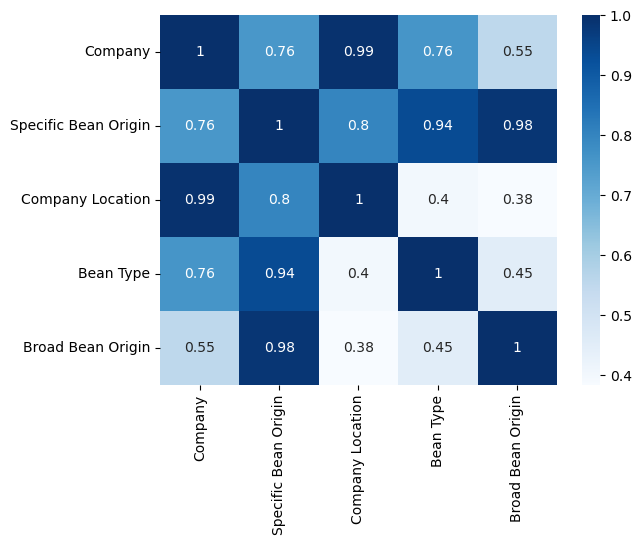

In [25]:
import seaborn as sns

sns.heatmap(cramer, cmap='Blues', annot=True);

In [26]:
def select_top3_corr_cols(col_in):
    select_df = cramer[col_in].sort_values(ascending=False)
    return select_df[1:].index.to_list()

In [27]:
def get_temp_df(col_in, col_on):
    temp_df = df_concat.groupby(col_on)[col_in] \
                        .agg(lambda x: np.random.choice(x.mode()) if len(x.mode()) > 0 else np.NaN) \
                        .dropna().reset_index()
    return temp_df

In [28]:
def fill_rows(row, col_on, temp_df):
    for variants, category in temp_df.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [29]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [30]:
def prepared_df(df, col_in):
    selected_cols = select_top3_corr_cols(col_in)
    print(selected_cols)
    for col_on in selected_cols:
        temp_df = get_temp_df(col_in, col_on)
        df[col_in] = df.apply(lambda row: fill_rows(row, col_on, temp_df) if row[col_in] is np.NaN else row[col_in], axis=1)
        df[col_in] = df[col_in].fillna('Other')

In [31]:
# cols_in = ['Bean Type', 'Broad Bean Origin']

# for col_in in cols_in:
#     prepared_df(train_df, col_in)

# for col_in in cols_in:
#     prepared_df(test_df, col_in)

In [32]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Review'] = test_df['Review'].astype('object')

In [33]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
dtype: object

In [34]:
train_df.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin'],
      dtype='object')

In [35]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(train_df[train_df['Bean Type'].notna()]['Bean Type'])

In [37]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Broad Bean Origin']

In [38]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].fillna('Temp')
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].fillna('Temp')

In [39]:
model_1 = CatBoostClassifier(verbose = 0, cat_features = cat_features)
model_1.fit(train_df[train_df['Bean Type'].notna()].drop(columns = ['Rating','Bean Type']).dropna(), target_encoded)

In [40]:
y_bean = model_1.predict(train_df.drop(columns = ['Rating','Bean Type']))
y_bean_test = model_1.predict(test_df.drop(columns = ['Bean Type']))

In [41]:
train_df['Bean Type'] = y_bean
test_df['Bean Type'] = y_bean_test

In [42]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].replace('Temp', np.NaN)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace('Temp', np.NaN)

In [43]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(train_df[train_df['Broad Bean Origin'].notna()]['Broad Bean Origin'])

In [44]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].replace('Temp', np.NaN)

In [45]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type']

In [46]:
model_2 = CatBoostClassifier(verbose = 1, cat_features = cat_features)
model_2.fit(train_df[train_df['Broad Bean Origin'].notna()].drop(columns = ['Rating','Broad Bean Origin']).dropna(), target_encoded)

Learning rate set to 0.079863
0:	learn: 3.9643096	total: 746ms	remaining: 12m 25s
1:	learn: 3.7235239	total: 2.67s	remaining: 22m 12s
2:	learn: 3.5866337	total: 5.21s	remaining: 28m 52s
3:	learn: 3.4511694	total: 6.38s	remaining: 26m 27s
4:	learn: 3.3712912	total: 8.77s	remaining: 29m 5s
5:	learn: 3.2789330	total: 11.3s	remaining: 31m 10s
6:	learn: 3.2118091	total: 13.9s	remaining: 32m 54s
7:	learn: 3.1477646	total: 16.7s	remaining: 34m 27s
8:	learn: 3.0787757	total: 17.6s	remaining: 32m 19s
9:	learn: 3.0316828	total: 20.1s	remaining: 33m 12s
10:	learn: 2.9862219	total: 23s	remaining: 34m 23s
11:	learn: 2.9389257	total: 25.8s	remaining: 35m 26s
12:	learn: 2.9017262	total: 28.6s	remaining: 36m 10s
13:	learn: 2.8609625	total: 31.5s	remaining: 36m 57s
14:	learn: 2.8226336	total: 34.1s	remaining: 37m 21s
15:	learn: 2.7899946	total: 37s	remaining: 37m 57s
16:	learn: 2.7587965	total: 40s	remaining: 38m 32s
17:	learn: 2.7311037	total: 42.8s	remaining: 38m 56s
18:	learn: 2.7035288	total: 45.3s

In [47]:
y_bean = model_2.predict(train_df.drop(columns = ['Rating','Broad Bean Origin']))
y_bean_test = model_2.predict(test_df.drop(columns = ['Broad Bean Origin']))

In [48]:
train_df['Broad Bean Origin'] = y_bean
test_df['Broad Bean Origin'] = y_bean_test

In [49]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,8,72
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,8,72
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,1,60
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,8,15
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,8,35


In [50]:
train_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [51]:
test_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [52]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                 int64
Broad Bean Origin         int64
dtype: object

In [53]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
test_df['Review'] = test_df['Review'].astype('object')

In [54]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [55]:
X = train_df[cols]
target = train_df['Rating']
test = test_df[cols]

In [56]:
mm_scaler = MinMaxScaler()
scaler = StandardScaler()

X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(test[['REF']])

In [57]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [58]:
# label_enc = LabelEncoder()
# temp_df = pd.concat([X, test], axis=0)
# label_enc.fit(temp_df['Bean Type'])
# X['Bean Type'] = label_enc.transform(X['Bean Type'])  
# test['Bean Type'] = label_enc.transform(cleaned_test['Bean Type'])

In [59]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481934,U.K.,8,72
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481934,Switzerland,8,72
2,Dark Forest,Tanzania,0.795583,2015,0.444824,U.S.A.,1,60
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481934,U.S.A.,8,15
4,Pralus,"Java, Indonesie",0.013867,2006,0.537598,France,8,35
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.630371,U.K.,8,35
1251,Marana,Cusco,0.965074,2016,0.444824,Peru,2,44
1252,Arete,Nacional,0.785311,2015,0.407715,U.S.A.,4,44
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481934,U.S.A.,8,15


In [60]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                     float64
Review                   object
Cocoa Percent           float16
Company Location         object
Bean Type                 int64
Broad Bean Origin         int64
dtype: object

In [61]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [62]:
# def objective_catboost(trial):
#     max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
#     learning_rate = trial.suggest_float("learning_rate", 0.001, 0.2, log=True)
#     n_estimators = trial.suggest_int("n_estimators", 1800, 3000)
#     l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
#     random_strength = trial.suggest_float("random_strength", 0, 10)
#     bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
#     # border_count = trial.suggest_int("border_count", 32, 255)

#     model = CatBoostRegressor(
#         cat_features=cat_features,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         n_estimators=n_estimators,
#         l2_leaf_reg=l2_leaf_reg,
#         random_strength=random_strength,
#         bagging_temperature=bagging_temperature,
#         # border_count=border_count,
#         silent=True
#     )

#     score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_catboost, n_trials=250, n_jobs=-1)

In [ ]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.


# params = {'learning_rate': 0.010085724934530157, 
# 'n_estimators': 2063, 
# 'l2_leaf_reg': 1.006603127309495, 
# 'random_strength': 1.4219666225791285, 
# 'bagging_temperature': 0.47554294906158245}

# # params = study.best_params
# model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
# model.fit(X, target)

In [8]:
def objective_catboost(trial):
    max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.2, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1800, 3000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("random_strength", 0, 10)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
    # border_count = trial.suggest_int("border_count", 32, 255)

    model = CatBoostRegressor(
        cat_features=cat_features,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        # border_count=border_count,
        silent=True
    )

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=100, n_jobs=-1)

[I 2025-05-12 21:28:33,178] A new study created in memory with name: no-name-251f9dda-f4ed-4657-a6ff-896e6aec620f
[W 2025-05-12 21:28:33,183] Trial 0 failed with parameters: {'learning_rate': 0.0010340372365951007, 'n_estimators': 2170, 'l2_leaf_reg': 4.732887937723967, 'random_strength': 8.237935934772775, 'bagging_temperature': 0.36347126585797285} because of the following error: NameError("name 'cat_features' is not defined").
Traceback (most recent call last):
  File "c:\Users\kuche\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kuche\AppData\Local\Temp\ipykernel_21340\230643369.py", line 11, in objective_catboost
    cat_features=cat_features,
                 ^^^^^^^^^^^^
NameError: name 'cat_features' is not defined
[W 2025-05-12 21:28:33,192] Trial 1 failed with parameters: {'learning_rate': 0.025820400162871508, 'n_estimators': 2391, 'l2_leaf_reg': 5.2437753698

NameError: name 'cat_features' is not defined

In [ ]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.

params = study.best_params
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
model.fit(X, target)

In [ ]:
pred = model.predict(test)

In [ ]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_24.csv", index=False)

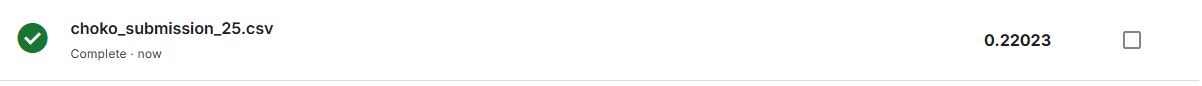